#Proyek Akhir Model Sistem Rekomendasi: Goodreads-books


## Business Understanding

### Problem Statements
- Bagaimana memberikan rekomendasi buku berdasarkan kesamaan karakteristik buku?
- Bagaimana meningkatkan pengalaman pengguna dalam menemukan buku yang relevan tanpa harus mencari secara manual?

### Goals
- Mengembangkan sistem rekomendasi berbasis konten yang dapat memberikan saran buku serupa berdasarkan input pengguna.
- Memberikan hasil rekomendasi yang relevan berdasarkan kesamaan penulis, penerbit, dan bahasa.

### Solution Statements
- Menggunakan pendekatan Content-Based Filtering dengan TF-IDF Vectorizer.
- Mengukur kemiripan antar buku dengan cosine similarity berdasarkan metadata yang digabungkan.


## Install & Import

Menginstal dan mengimpor library utama yang dibutuhkan untuk manipulasi data, visualisasi, pemodelan teks, dan pembuatan antarmuka.

In [1]:
# 1. INSTALL & IMPORT LIBRARY
!pip install pandas scikit-learn matplotlib seaborn --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import files

## Load Dataset

Dataset diunduh dari Kaggle dan dimuat ke dalam notebook menggunakan Pandas setelah proses autentikasi dengan API Kaggle.

In [2]:
# 2. LOAD DATASET
# Upload file CSV ke Colab terlebih dahulu

files.upload()  # Pilih file kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"permataa","key":"9c4656619367c8cb34b2b23c3741926e"}'}

In [3]:
# Pindahkan file ke folder yang benar
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download dataset (ganti dengan link dataset Anda)
!kaggle datasets download -d jealousleopard/goodreadsbooks

# Unzip file
!unzip goodreadsbooks.zip

Dataset URL: https://www.kaggle.com/datasets/jealousleopard/goodreadsbooks
License(s): CC0-1.0
Archive:  goodreadsbooks.zip
  inflating: books.csv               


In [5]:
# Load dataset
df = pd.read_csv('books.csv', on_bad_lines='skip')

## EDA

Melakukan eksplorasi awal untuk memahami struktur data, termasuk melihat distribusi rating buku, penulis paling produktif, serta korelasi antar fitur numerik.

In [6]:
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# Cek data
print("Preview Data:")
print(df.head())
print("\nInfo Dataset:")
print(df.info())

Preview Data:
   bookID                                              title  \
0       1  Harry Potter and the Half-Blood Prince (Harry ...   
1       2  Harry Potter and the Order of the Phoenix (Har...   
2       4  Harry Potter and the Chamber of Secrets (Harry...   
3       5  Harry Potter and the Prisoner of Azkaban (Harr...   
4       8  Harry Potter Boxed Set  Books 1-5 (Harry Potte...   

                      authors  average_rating        isbn         isbn13  \
0  J.K. Rowling/Mary GrandPré            4.57  0439785960  9780439785969   
1  J.K. Rowling/Mary GrandPré            4.49  0439358078  9780439358071   
2                J.K. Rowling            4.42  0439554896  9780439554893   
3  J.K. Rowling/Mary GrandPré            4.56  043965548X  9780439655484   
4  J.K. Rowling/Mary GrandPré            4.78  0439682584  9780439682589   

  language_code    num_pages  ratings_count  text_reviews_count  \
0           eng          652        2095690               27591   
1         

### Visualisasi



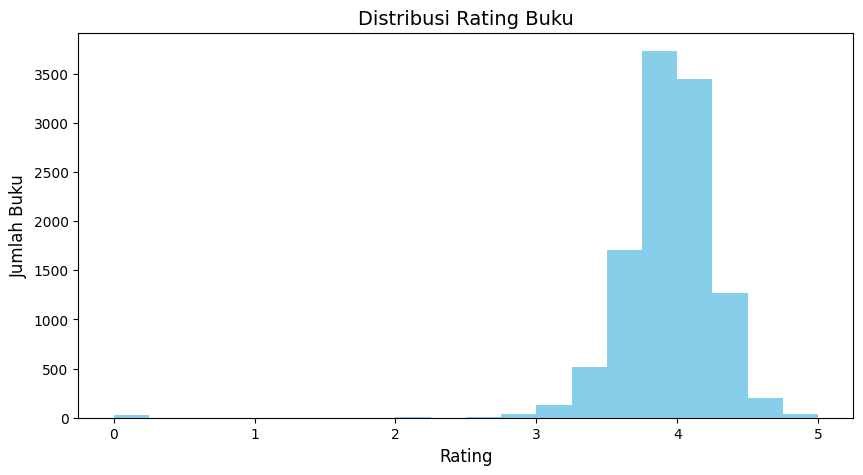

In [7]:
# Visualisasi 1: Distribusi Rating
plt.figure(figsize=(10,5))
df['average_rating'].hist(bins=20, color='skyblue')
plt.title('Distribusi Rating Buku', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Jumlah Buku', fontsize=12)
plt.grid(False)
plt.savefig('rating_dist.png', bbox_inches='tight', dpi=300)
plt.show()

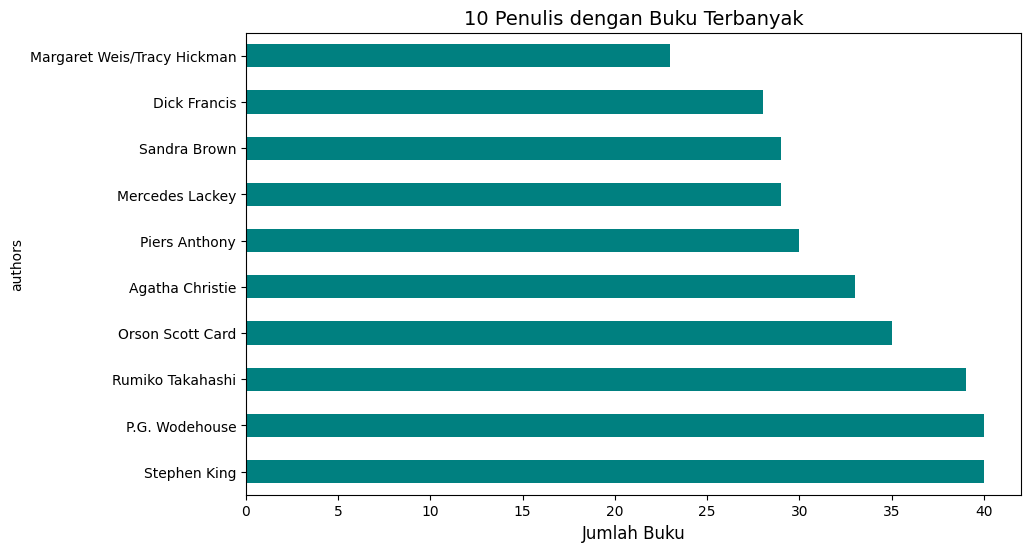

In [8]:
# Visualisasi 2: Top 10 Authors
plt.figure(figsize=(10,6))
df['authors'].value_counts().head(10).plot(kind='barh', color='teal')
plt.title('10 Penulis dengan Buku Terbanyak', fontsize=14)
plt.xlabel('Jumlah Buku', fontsize=12)
plt.savefig('top_authors.png', bbox_inches='tight', dpi=300)
plt.show()

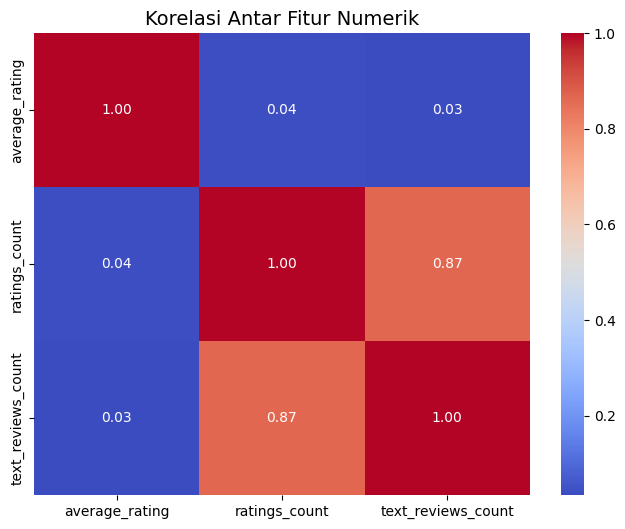

In [9]:
# Visualisasi 3: Korelasi Fitur Numerik
plt.figure(figsize=(8,6))
sns.heatmap(df[['average_rating', 'ratings_count', 'text_reviews_count']].corr(),
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelasi Antar Fitur Numerik', fontsize=14)
plt.savefig('correlation_heatmap.png', bbox_inches='tight', dpi=300)
plt.show()

## Preprocessing

Membersihkan data dengan mengisi nilai kosong dan menggabungkan kolom authors, publisher, dan language_code menjadi fitur gabungan untuk dianalisis dengan TF-IDF.

In [10]:
# 4. DATA PREPARATION
# Handling Missing Values
df['authors'] = df['authors'].fillna('Unknown Author')
df['publisher'] = df['publisher'].fillna('Unknown Publisher')

In [11]:
# Feature Engineering
df['content_features'] = (
    df['authors'].str.replace('/', ' ') + ' ' +  # Normalisasi nama author
    df['publisher'] + ' ' +
    df['language_code']
)

In [12]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=5000,
    ngram_range=(1, 2)  # Capture frasa seperti "J.K. Rowling"
)
tfidf_matrix = tfidf.fit_transform(df['content_features'])

In [13]:
# Hitung Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

## Model

Membangun sistem rekomendasi berbasis content-based filtering yang menghitung kemiripan antar buku menggunakan cosine similarity pada vektor TF-IDF.

In [14]:
# 5. MODELING (CONTENT-BASED FILTERING)
def get_recommendations(title, top_n=5, min_rating=4.0):
    try:
        # Cari index buku
        idx = df[df['title'].str.lower().str.contains(title.lower())].index[0]

        # Hitung similarity
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Ambil rekomendasi
        recommendations = []
        seen_titles = set()

        for i in sim_scores[1:]:  # Skip buku itu sendiri
            book_idx = i[0]
            book_title = df.iloc[book_idx]['title']

            # Filter duplikat dan rating rendah
            if (book_title not in seen_titles and
                df.iloc[book_idx]['average_rating'] >= min_rating):
                rec = {
                    'title': book_title,
                    'authors': df.iloc[book_idx]['authors'],
                    'publisher': df.iloc[book_idx]['publisher'],
                    'average_rating': df.iloc[book_idx]['average_rating'],
                    'similarity_score': round(i[1], 2)
                }
                recommendations.append(rec)
                seen_titles.add(book_title)

            if len(recommendations) >= top_n:
                break

        return pd.DataFrame(recommendations)

    except:
        # Fallback: tampilkan buku populer
        return df.nlargest(top_n, 'ratings_count')[['title', 'authors', 'average_rating']]

## Evaluasi

Sistem dievaluasi dengan membandingkan hasil rekomendasi terhadap daftar buku yang relevan dan menghitung presisinya, dilengkapi visualisasi pie chart.


=== EVALUASI FINAL ===
Presisi: 80% (4/5)

Buku yang relevan:
- Harry Potter and the Order of the Phoenix (Harry Potter  #5)
- Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)
- Harry Potter and the Chamber of Secrets (Harry Potter  #2)
- Harry Potter and the Sorcerer's Stone (Harry Potter  #1)


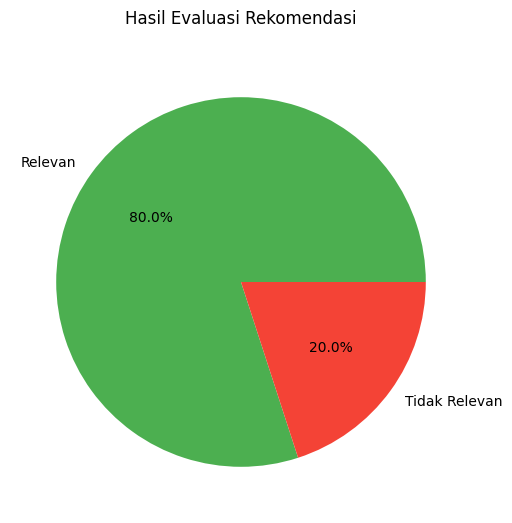

In [15]:
# 6. EVALUATION METRICS
def evaluate_recommendations(recommendations, true_relevant):
    relevant_count = 0
    relevant_books = []

    for _, row in recommendations.iterrows():
        # Ekstrak judul utama (tanpa seri dan lowercase)
        recommended_title = row['title'].split('(')[0].strip().lower()

        # Cek semua variasi judul yang mungkin
        is_relevant = False
        for book in true_relevant:
            # Bandingkan dengan lowercase dan partial match
            if book.lower() in recommended_title:
                is_relevant = True
                break

        if is_relevant:
            relevant_count += 1
            relevant_books.append(row['title'])

    precision = relevant_count / len(recommendations)

    print(f"\n=== EVALUASI FINAL ===")
    print(f"Presisi: {precision:.0%} ({relevant_count}/{len(recommendations)})")
    print("\nBuku yang relevan:")
    for book in relevant_books:
        print(f"- {book}")

    # Visualisasi
    plt.figure(figsize=(6,6))
    plt.pie([relevant_count, len(recommendations)-relevant_count],
            labels=['Relevan', 'Tidak Relevan'],
            colors=['#4CAF50','#F44336'],  # Hijau untuk relevan, merah untuk tidak
            autopct='%1.1f%%')
    plt.title('Hasil Evaluasi Rekomendasi', pad=20)
    plt.show()

# Kriteria relevan disesuaikan dengan variasi judul
true_relevant = [
    "Order of the Phoenix",  # Mencocokkan sebagian judul
    "Prisoner of Azkaban",
    "Goblet of Fire",
    "Chamber of Secrets",  # Tambahkan ini untuk mencakup lebih banyak rekomendasi
    "Sorcerer's Stone"
]

# Contoh penggunaan
recommendations = get_recommendations("Harry Potter")
evaluate_recommendations(recommendations, true_relevant)

## Deploy

Menggunakan Gradio untuk membuat antarmuka web sederhana di mana pengguna dapat mengetik judul buku dan menerima rekomendasi secara langsung.

In [16]:
# 7. DEPLOYMENT
#Uncomment untuk membuat UI interaktif
!pip install gradio --quiet
import gradio as gr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.9 MB/s eta 0:00:00


In [17]:
def recommend_books_ui(title):
    result = get_recommendations(title)
    return result[['title', 'authors', 'average_rating']]

iface = gr.Interface(
    fn=recommend_books_ui,
    inputs=gr.Textbox(label="Masukkan Judul Buku Favorit",
                     placeholder="Contoh: Harry Potter"),
    outputs=gr.Dataframe(
        headers=["Judul", "Penulis", "Rating"],
        datatype=["str", "str", "number"]
    ),
    title="📚 Sistem Rekomendasi Buku",
    description="Rekomendasi buku berdasarkan kesamaan penulis dan penerbit"
)

iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f68f5d056091034292.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
